## <img src="./logo_UTN.svg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Práctico 4
#### Valentín Pertierra

***
## Filtrado


<div class="alert alert-block alert-info">
<b>1)</b> Para el siguiente filtro digital se pide:

</div>

 $$ y(k) = \frac{1}{N} \sum_{i=0}^{N-1} x(k-i)  $$
 
 Para N = [3; 5]

   a) El diagrama de polos y ceros y su respuesta de módulo y fase



<img src="./escriba_aqui.png" align="center" width="50%" /> 


   b) Corrobore su respuesta mediante la simulación computacional


In [55]:
## Inicialización del Notebook del TP4

import numpy as np
from pandas import DataFrame
from IPython.display import HTML
from scipy import signal as sig

import scipy.io as sio
from scipy.fftpack import fft
from time import time
from scipy.interpolate import CubicSpline

# Insertar aquí el código para inicializar tu notebook
########################################################

import matplotlib as mpl
#%%  Inicialización de librerías
# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
mpl.rcParams['figure.figsize'] = (10,10)

import matplotlib.pyplot as plt

#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

def vertical_flaten(a):
    
    return a.reshape(a.shape[0],1)


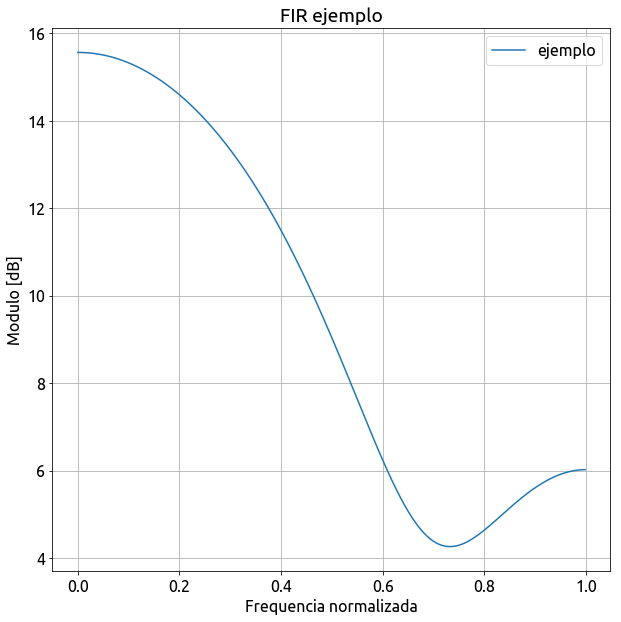

In [49]:
##########################################
# Acá podés generar los gráficos pedidos #
##########################################

ww, hh = sig.freqz(np.array([1, 2, 3]), 1)
ww = ww / np.pi

plt.figure(1)

plt.plot(ww, 20 * np.log10(abs(hh)), label='ejemplo')

plt.title('FIR ejemplo')
plt.xlabel('Frequencia normalizada')
plt.ylabel('Modulo [dB]')
plt.grid(which='both', axis='both')

axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()


<div class="alert alert-block alert-info">
<b>2)</b> Para el siguiente filtro digital se pide:

</div>


$$ h(k) = (-1, 1) $$
 


   a) El diagrama de polos y ceros y su respuesta de módulo y fase



<img src="./escriba_aqui.png" align="center" width="50%" /> 


   b) Corrobore su respuesta mediante simulación computacional


In [50]:

##########################################
# Acá podés generar los gráficos pedidos #
##########################################


<div class="alert alert-block alert-info">
<b>3)</b> Para el siguiente filtro digital se pide:

</div>


<img src="./comb.png" align="center" width="30%" /> 


Para $N= (2; 4)$ y $b = -1$

   a) El diagrama de polos y ceros y su respuesta de módulo y fase



<img src="./escriba_aqui.png" align="center" width="50%" /> 


   b) Corrobore su respuesta mediante simulación computacional


In [51]:

##########################################
# Acá podés generar los gráficos pedidos #
##########################################



<div class="alert alert-block alert-info">
<b>4)</b> En el archivo <i>ECG_TP4.mat</i> encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:
</div>

 - Ruido causado por el movimiento de los electrodos (Alta frecuencia)
 - Ruido muscular (Alta frecuencia)
 - Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia)
 

<div class="alert alert-block alert-success">
<b>Ayuda:</b> Los latidos presentes en el registro de ECG, alineados y clasificados (de origen normal y ventricular) poseen las siguientes características temporales y frecuenciales:
</div>


<img src="./latidos_tiempo.png" align="center" width="80%" /> 

<img src="./latido_promedio.png" align="center" width="80%" /> 

<img src="./latidos_espectro.png" align="center" width="80%" /> 


### Archivo *ECG_TP4.mat*
(variables)
 - **ecg_lead**: Registro de ECG muestreado a $fs=1$ KHz durante una prueba de esfuerzo
 - **qrs_pattern1**: Complejo de ondas QRS normal
 - **heartbeat_pattern1**: Latido normal
 - **heartbeat_pattern2**: Latido de origen ventricular
 - **qrs_detections**: vector con las localizaciones (en # de muestras) donde ocurren los latidos
 
a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a *suavidad* de los trazos y nivel isoeléctrico nulo.
 

In [2]:
# Cargo la señal de ECG
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N = len(ecg_one_lead)

fs = 1000
fn = fs/2

# Genero un vector con el tiempo
t = np.linspace(0,(N-1)/fs,N)

C:\Users\Valentin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


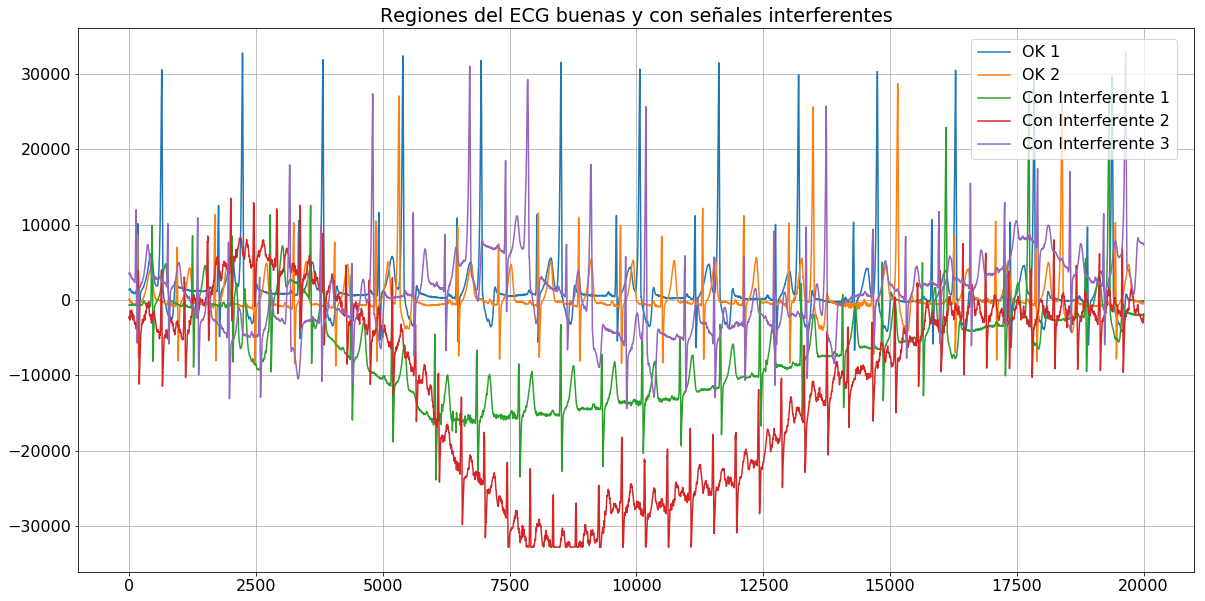

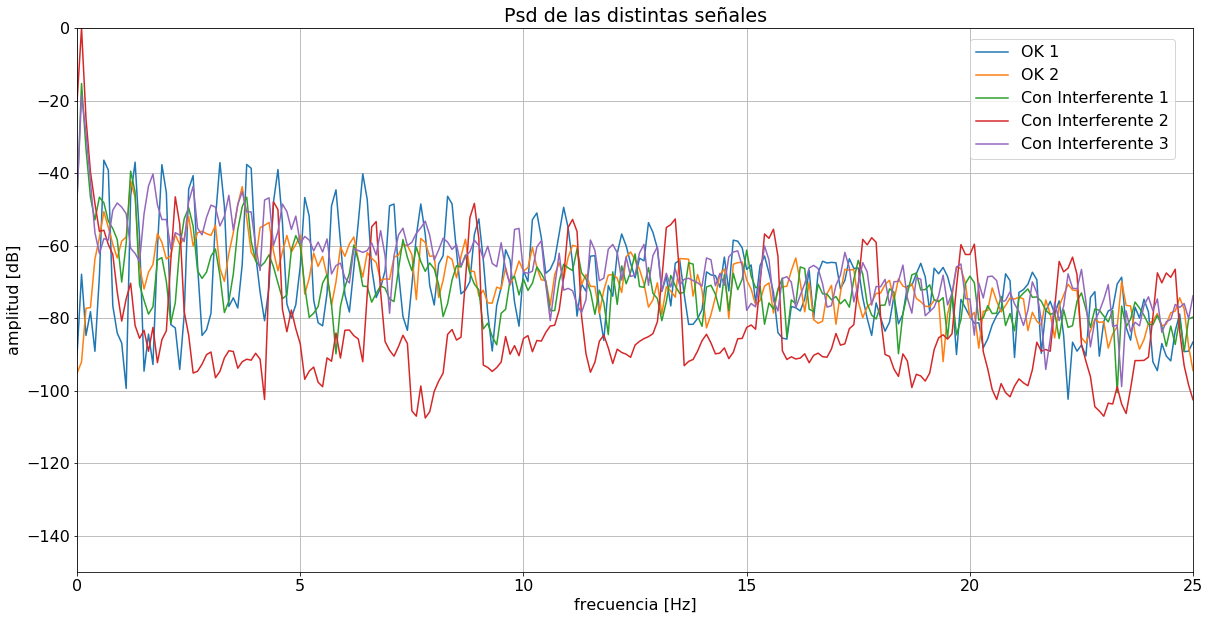

In [48]:

# Para determinar la plantilla del filtro, grafico la psd de las zonas del ECG 
# que contienen latidos sin señales interferentes y zonas afectadas por la interferente.
# De este forma determino que parte del espectro contiene señales interferentes

# Determino las regiones "buenas" y afectadas por interferentes
regionOk_1 = np.arange(30000,50000, dtype='uint')
regionOk_2 = np.arange(60000,80000, dtype='uint')
regionInt_1 = np.arange(100000,120000, dtype='uint')
regionInt_2 = np.arange(725000,745000, dtype='uint')
regionInt_3 = np.arange(920000,940000, dtype='uint')

# Obtengo las psd con el metodo de Welch
L = 10000 #Largo de los bloques a promediar

psdWelch = np.zeros(shape=((L//2)+1,5))
f,psdWelch[:,0] = sig.welch(ecg_one_lead[regionOk_1,0], fs, 'bartlett',nperseg=L, noverlap=L//2)
f,psdWelch[:,1] = sig.welch(ecg_one_lead[regionOk_2,0], fs, 'bartlett',nperseg=L, noverlap=L//2)
f,psdWelch[:,2] = sig.welch(ecg_one_lead[regionInt_1,0], fs, 'bartlett',nperseg=L, noverlap=L//2)
f,psdWelch[:,3] = sig.welch(ecg_one_lead[regionInt_2,0], fs, 'bartlett',nperseg=L, noverlap=L//2)
f,psdWelch[:,4] = sig.welch(ecg_one_lead[regionInt_3,0], fs, 'bartlett',nperseg=L, noverlap=L//2)

# Normalizo los resultados
psdWelch = psdWelch/np.max(psdWelch)


# Grafico las regiones del ECG 
plt.figure(figsize=(20,10))
plt.title("Regiones del ECG buenas y con señales interferentes")
plt.plot(ecg_one_lead[regionOk_1,0],label = 'OK 1')
plt.plot(ecg_one_lead[regionOk_2,0],label = 'OK 2')
plt.plot(ecg_one_lead[regionInt_1,0],label = 'Con Interferente 1')
plt.plot(ecg_one_lead[regionInt_2,0],label = 'Con Interferente 2')
plt.plot(ecg_one_lead[regionInt_3,0],label = 'Con Interferente 3')
plt.legend(bbox_to_anchor=(0.80, 0.98), loc=2, borderaxespad=0.)
plt.grid()


# Grafico las psd regiones del ECG 
plt.figure(figsize=(20,10))
plt.title("Psd de las distintas señales")
plt.plot(f,20*np.log10(psdWelch[:,0]),label = 'OK 1')
plt.plot(f,20*np.log10(psdWelch[:,1]),label = 'OK 2')
plt.plot(f,20*np.log10(psdWelch[:,2]),label = 'Con Interferente 1')
plt.plot(f,20*np.log10(psdWelch[:,3]),label = 'Con Interferente 2')
plt.plot(f,20*np.log10(psdWelch[:,4]),label = 'Con Interferente 3')
plt.legend(bbox_to_anchor=(0.80, 0.98), loc=2, borderaxespad=0.)
plt.axis([0,25,-150,0])
plt.ylabel('amplitud [dB]')
plt.xlabel('frecuencia [Hz]')
plt.grid()

<div class="alert alert-block alert-success">
De la densidad espectral de potencia de puede ver que las señales interferentes tienen energía en la banda comprendidad entre 0Hz y 0,5Hz. En esta misma banda la señal de ECG buena se encuentra 80dB por debajo de la interferente. Teniendo esto en cuenta, defino el comienzo de la banda de paso de la plantilla en fc0 = 0,5Hz y el fin de la banda de detenida 0 en fs0 = 0,25Hz
</div>

In [49]:
# Calculo donde esta el 90% de la energia de la señal OK
enTot = np.sum(psdWelch[:,0])
en90 = 0.9*enTot

suma = 0
for i in range(len(psdWelch[:,0])):
    suma += psdWelch[i,0]
    if suma >= en90:
        frec90 = f[i]
        break

print("En la banda entre f=0Hz y f="+str(frec90)+"Hz se encuentra el 90% de la energía de la se señal sin interferente")

En la banda entre f=0Hz y f=14.700000000000001Hz se encuentra el 90% de la energía de la se señal sin interferente


<div class="alert alert-block alert-success">
Con esta informacion defino el fin de la banda de paso en fc1=15Hz y el comienzo de la banda de detenida 1 en fs1=17Hz
</div>

In [10]:
# Defina la plantilla del filtro

fs0 = 0.25 # fin de la banda de detenida 0
fc0 = 0.5 # comienzo de la banda de paso
fc1 = 15 # fin de la banda de paso
fs1 = 17 # comienzo de la banda de detenida 1


c) Diseñe **al menos** dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño
  

C:\Users\Valentin\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
C:\Users\Valentin\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
C:\Users\Valentin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


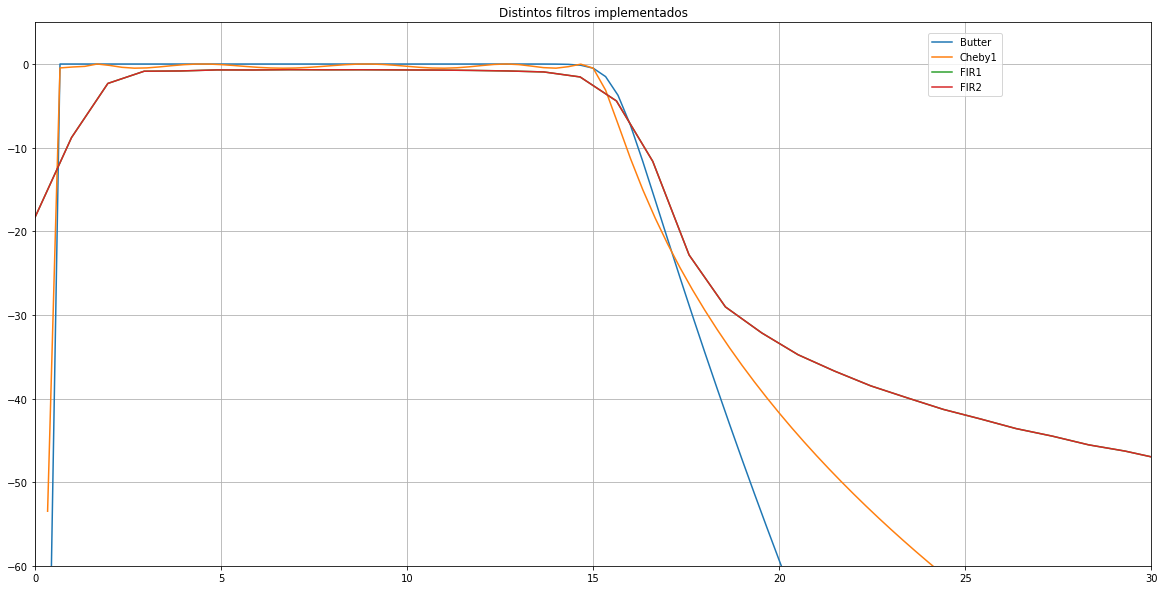

In [14]:
# Atenuacion en la banda de paso y de stop en dB
attPaso = 0.5
attStop = 20.0

fecuencias = np.array([0.0,fs0+1,fc0+1,fc1,fs1,fn])/fn
ganancias = np.array([-attStop*10, -attStop*10, -attPaso, -attPaso, -attStop*10, -attStop*10])
ganancias = 10**(ganancias/20)

# Obtengo los parametros de los distintos filtros
bpSosButter = sig.iirdesign(wp=np.array([fc0,fc1])/fn,ws=np.array([fs0,fs1])/fn,gpass=attPaso,gstop=attStop,analog=False,ftype='butter',output='sos')
bpSosCheby1 = sig.iirdesign(wp=np.array([fc0,fc1])/fn,ws=np.array([fs0,fs1])/fn,gpass=attPaso,gstop=attStop,analog=False,ftype='cheby1',output='sos')

numFIR1 = sig.firwin2(1001, fecuencias,ganancias, window = 'bartlett')
numFIR2 = sig.firwin2(501, fecuencias,ganancias, window = 'blackmanharris')
denFIR = 1.0

wButter,hButter = sig.sosfreqz(bpSosButter, worN=1500)
wCheby1,hCheby1 = sig.sosfreqz(bpSosCheby1, worN=1500)
wFIR1,hFIR1 = sig.freqz(numFIR1, denFIR)
wFIR2,hFIR2 = sig.freqz(numFIR1, denFIR)

# Grafico la respuesta del filtro
plt.figure(figsize=(20,10))
plt.title("Distintos filtros implementados")
plt.plot(fn*(wButter/np.pi),20*np.log10(np.abs(hButter)),label = 'Butter')
plt.plot(fn*(wCheby1/np.pi),20*np.log10(np.abs(hCheby1)),label = 'Cheby1')
plt.plot(fn*(wFIR1/np.pi),20*np.log10(np.abs(hFIR1)),label = 'FIR1')
plt.plot(fn*(wFIR2/np.pi),20*np.log10(np.abs(hFIR2)),label = 'FIR2')
plt.legend(bbox_to_anchor=(0.80, 0.98), loc=2, borderaxespad=0.)
plt.axis([0,30,-60,5])
plt.grid()


d) Evalúe el rendimiento de los filtros que haya diseñado: 

 1. Verifique que filtra las señales interferentes
 2. Verifique que es inocuo en las zonas donde no hay interferentes



In [23]:
# Filtro la señal de ECG
ECG_butter = sig.sosfiltfilt(bpSosButter, ecg_one_lead) 
ECG_Cheby1 = sig.sosfiltfilt(bpSosCheby1, ecg_one_lead) 
ECG_FIR1 = sig.filtfilt(numFIR1, denFIR, ecg_one_lead)
ECG_FIR2 = sig.filtfilt(numFIR2, denFIR, ecg_one_lead)

C:\Users\Valentin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


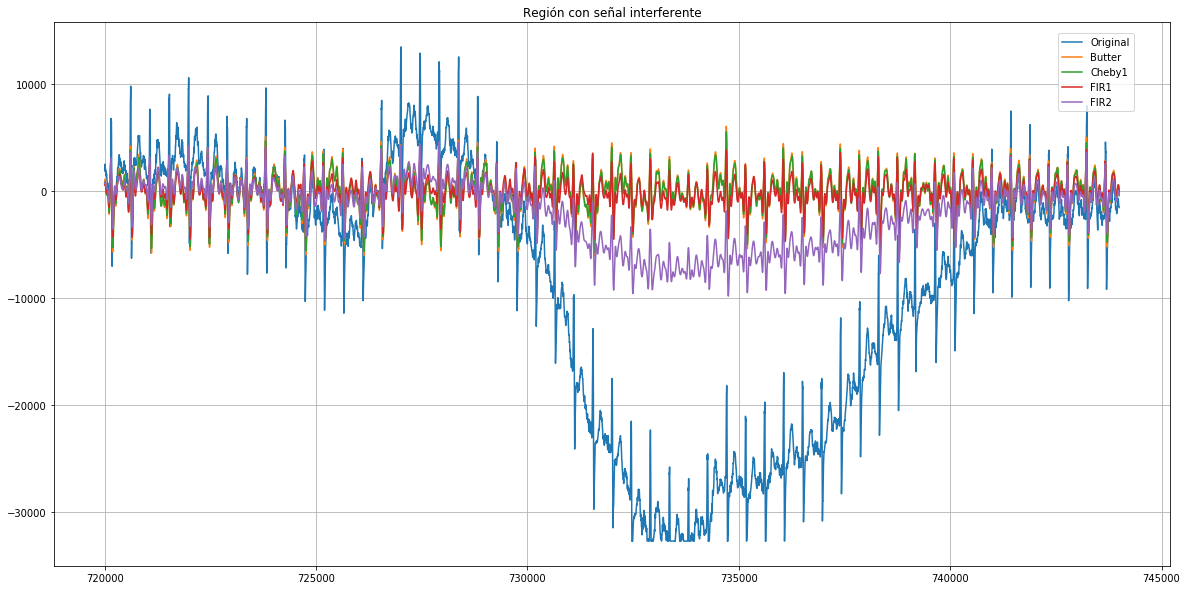

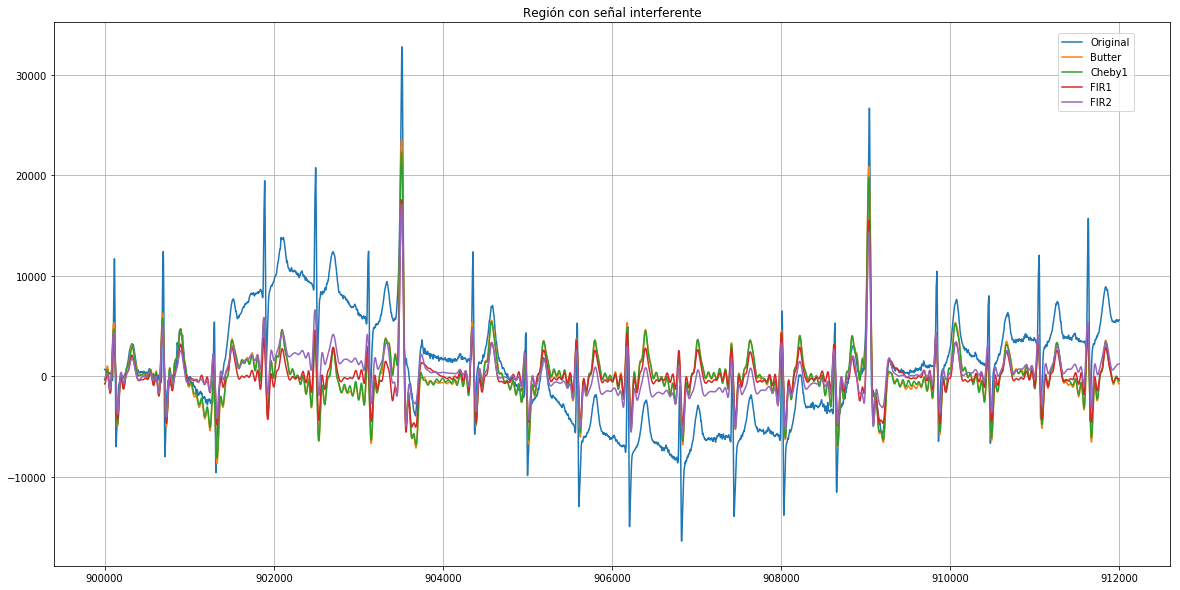

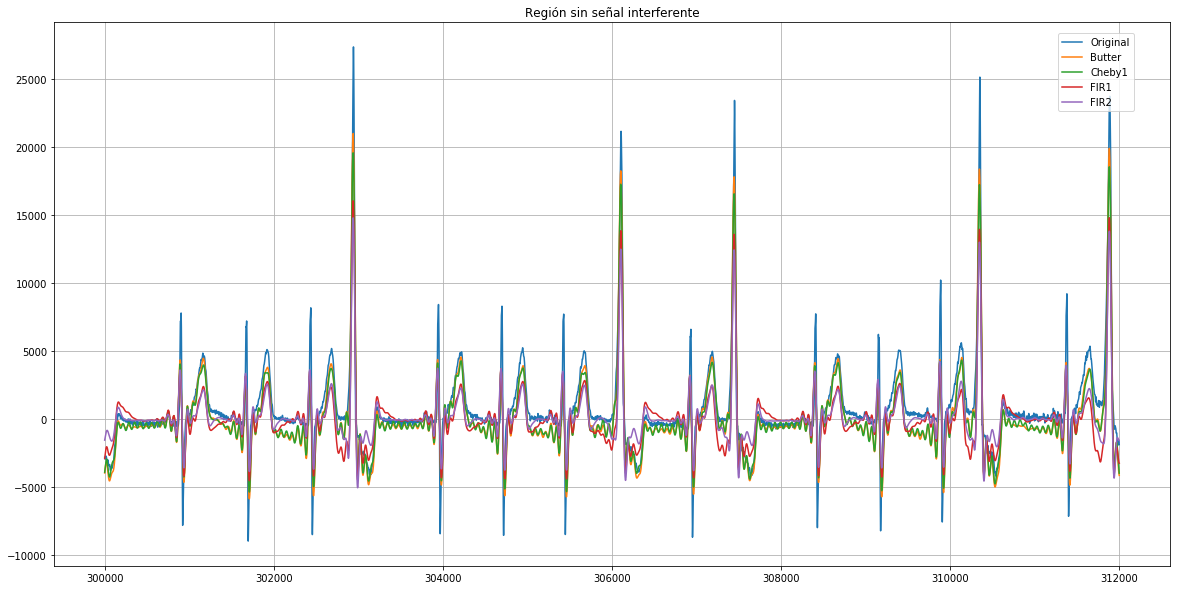

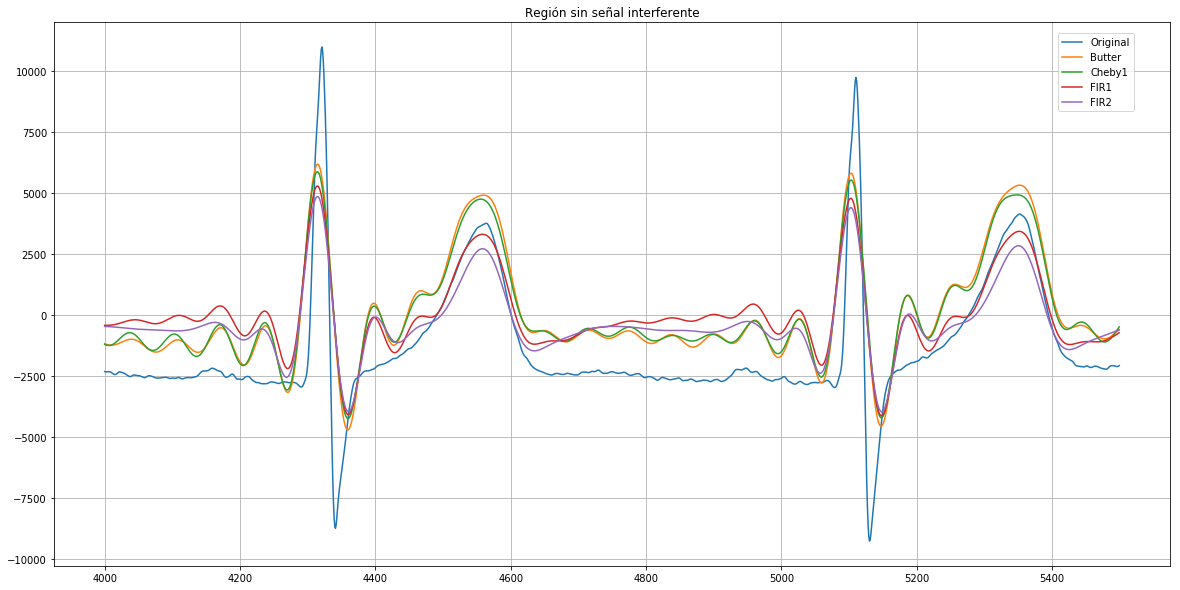

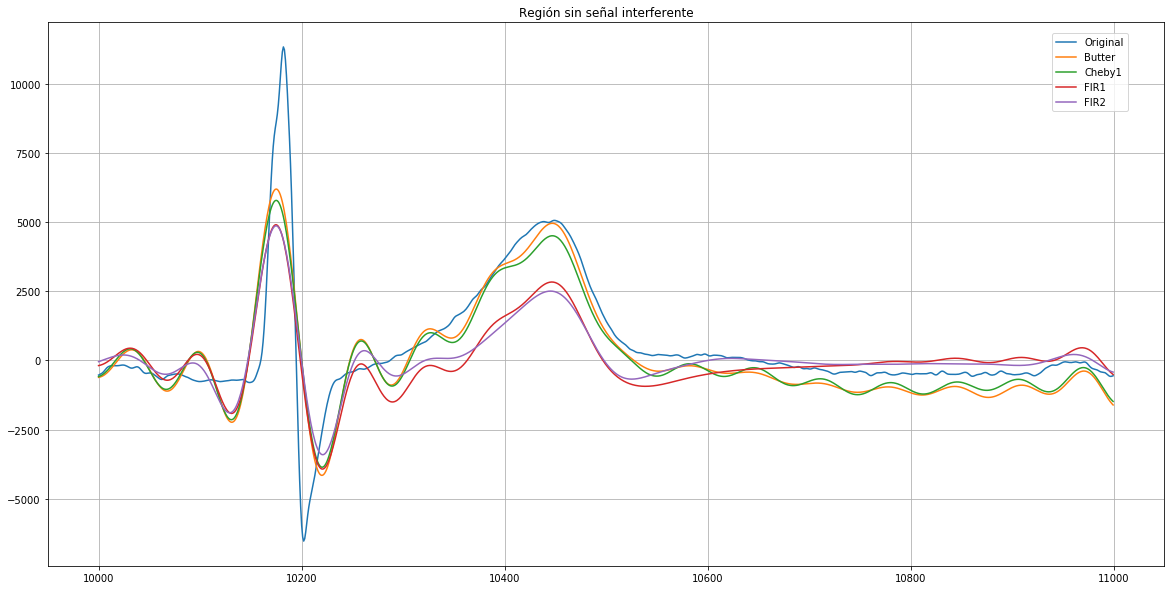

In [24]:
# Puede tomar como referencia los siguientes segmentos, aunque si lo considera, también
# puede incluir otros que considere importantes para evaluar el rendimiento.
region = [np.arange(12*60*fs, 12.4*60*fs,dtype='uint') , np.arange(15*60*fs, 15.2*60*fs,dtype='uint')]

for reg in region:
    # Grafico la señal original y la filtrada en las zonas de interes
    plt.figure(figsize=(20,10))
    plt.title("Región con señal interferente")
    plt.plot(reg,ecg_one_lead[reg],label = 'Original')
    plt.plot(reg,ECG_butter[reg],label = 'Butter')
    plt.plot(reg,ECG_Cheby1[reg],label = 'Cheby1')
    plt.plot(reg,ECG_FIR1[reg],label = 'FIR1')
    plt.plot(reg,ECG_FIR2[reg],label = 'FIR2')
    plt.legend(bbox_to_anchor=(0.90, 0.98), loc=2, borderaxespad=0.)
    plt.grid()


region = [np.arange(5*60*fs, 5.2*60*fs,dtype='uint') , np.arange(4000, 5500,dtype='uint'), np.arange(10e3, 11e3,dtype='uint')]

for reg in region:
    # Grafico la señal original y la filtrada en las zonas de interes
    plt.figure(figsize=(20,10))
    plt.title("Región sin señal interferente")
    plt.plot(reg,ecg_one_lead[reg],label = 'Original')
    plt.plot(reg,ECG_butter[reg],label = 'Butter')
    plt.plot(reg,ECG_Cheby1[reg],label = 'Cheby1')
    plt.plot(reg,ECG_FIR1[reg],label = 'FIR1')
    plt.plot(reg,ECG_FIR2[reg],label = 'FIR2')
    plt.legend(bbox_to_anchor=(0.90, 0.98), loc=2, borderaxespad=0.)
    plt.grid()





<div class="alert alert-block alert-warning">
<b>Respuesta:</b> Escriba aquí su respuesta.
</div>

<div class="alert alert-block alert-info">
<b>5)</b> Utilice las siguientes metodologías <b>no lineales</b> de estimación-substracción para la remoción de la interferencia de línea de base, y compare con las técnicas lineales del punto anterior en las mismas regiones. Luego discuta las ventajas y desventajas de cada técnica.
</div>

a) Estimación del movimiento de línea de base a partir del filtrado de mediana. A partir de la siguiente estimación del movimiento de línea de base 

$$ \hat{b} = \mathop{med}_{600} \{ \mathop{med}_{200} \{s\} \} $$

Donde $s$ representa la señal de ECG a partir de la que estimamos el movimiento de la línea de base $ \hat{b}$. El operador $\mathop{med}_{200}$ calcula muestra a muestra la mediana en los 200 ms previos a la muestra actual. Luego dicha estimación la substraemos para estimar la actividad eléctrica cardíaca $\hat{x}$

$$ \hat{x} = s - \hat{b} $$


<div class="alert alert-block alert-success">
<b>Ayuda:</b> Puede utilizar la implementación del <a href="https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#median-filter">filtro de mediana provista en <b>scipy.signal</b></a>
</div>

In [36]:
# Cargo la señal de ecg
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = np.reshape(ecg_one_lead,len(ecg_one_lead))

N = len(ecg_one_lead)

fs = 1000
fn = fs/2

In [37]:
# Con esto puedo calcular el tiempo que tarda en procesar
tStartMediana = time()

# Le aplico el filtro de mediana de 200 muestras
ecg_one_lead_med200 = sig.medfilt(ecg_one_lead,199)

# Le aplico el filtro de mediana de 600 muestras
# para obtener el estimador de la señal interferente
estB = sig.medfilt(ecg_one_lead_med200,599)

# Obtengo la señal de ECG sin la interferente
estX = ecg_one_lead - estB

# Mido el timepo que tardo
dtMediana = time()-tStartMediana


C:\Users\Valentin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


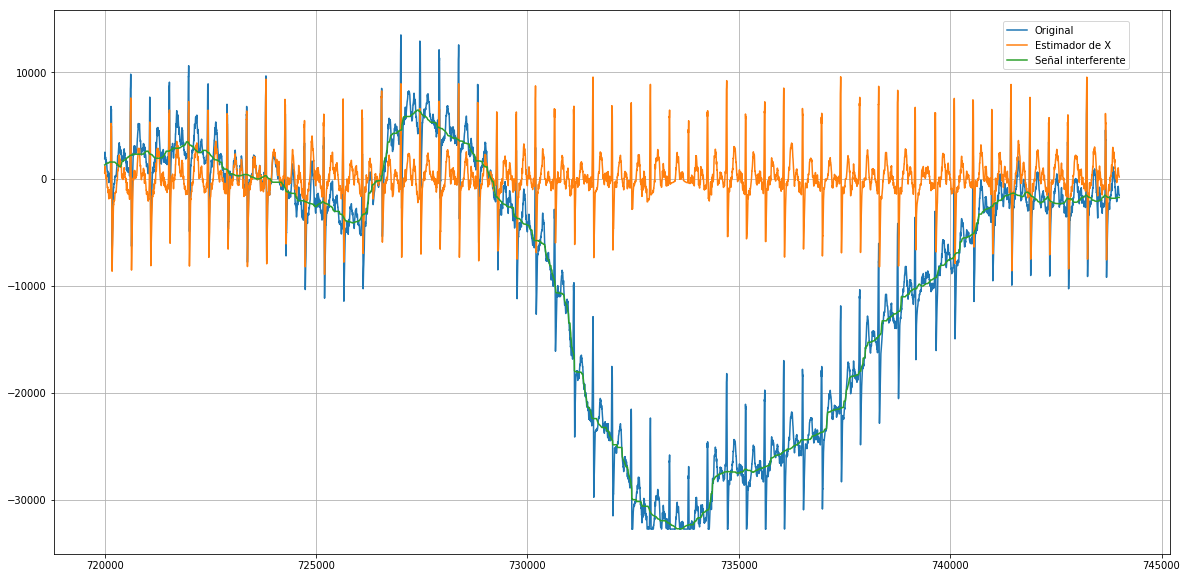

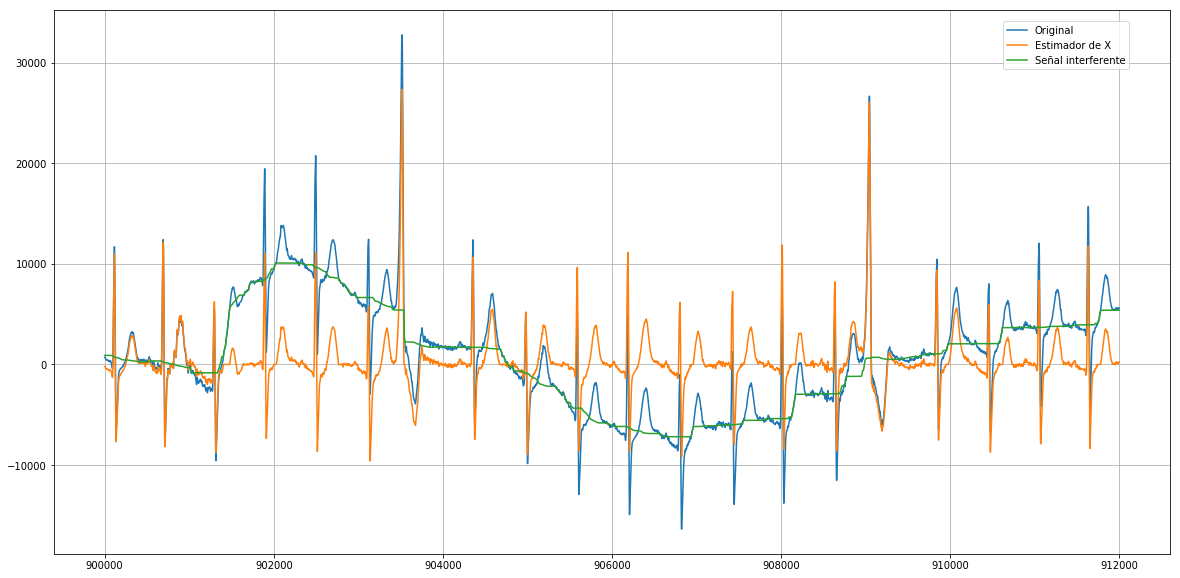

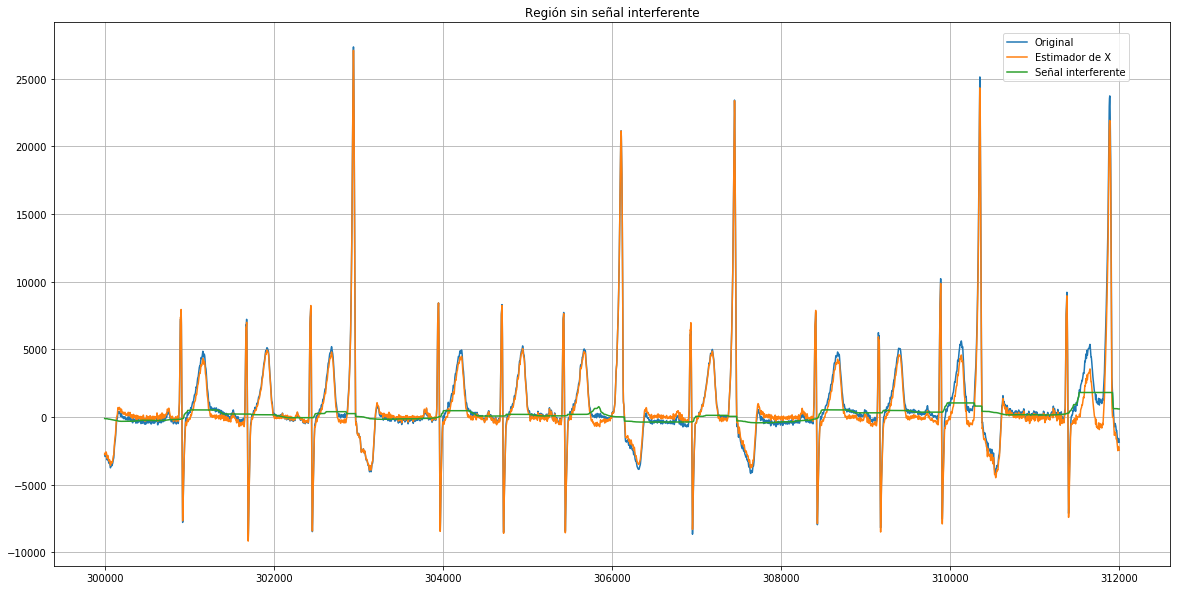

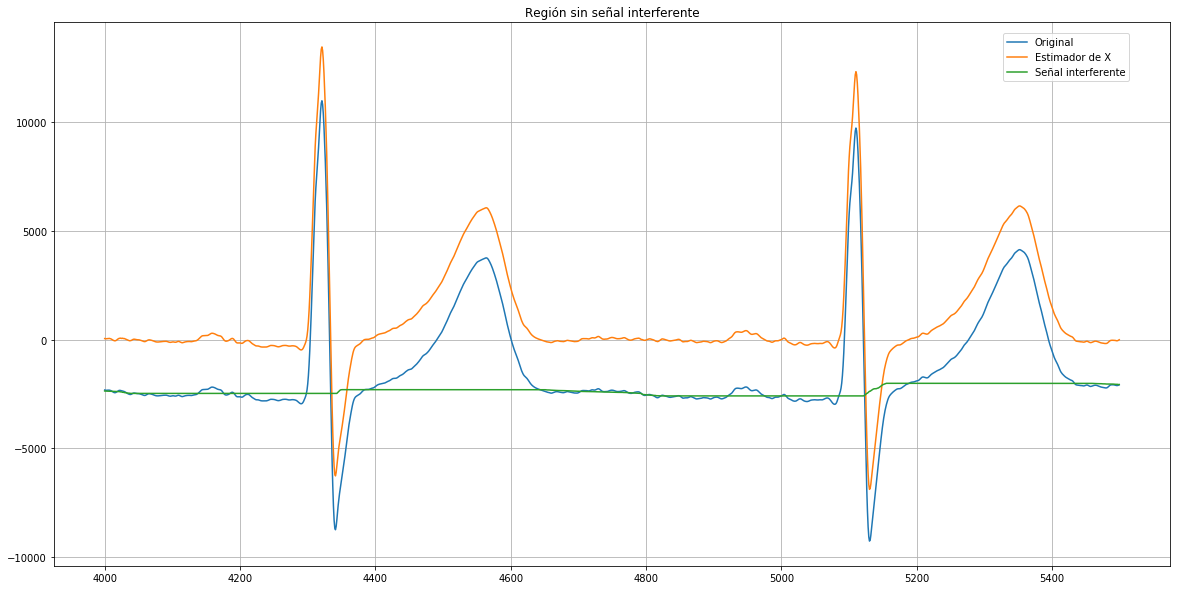

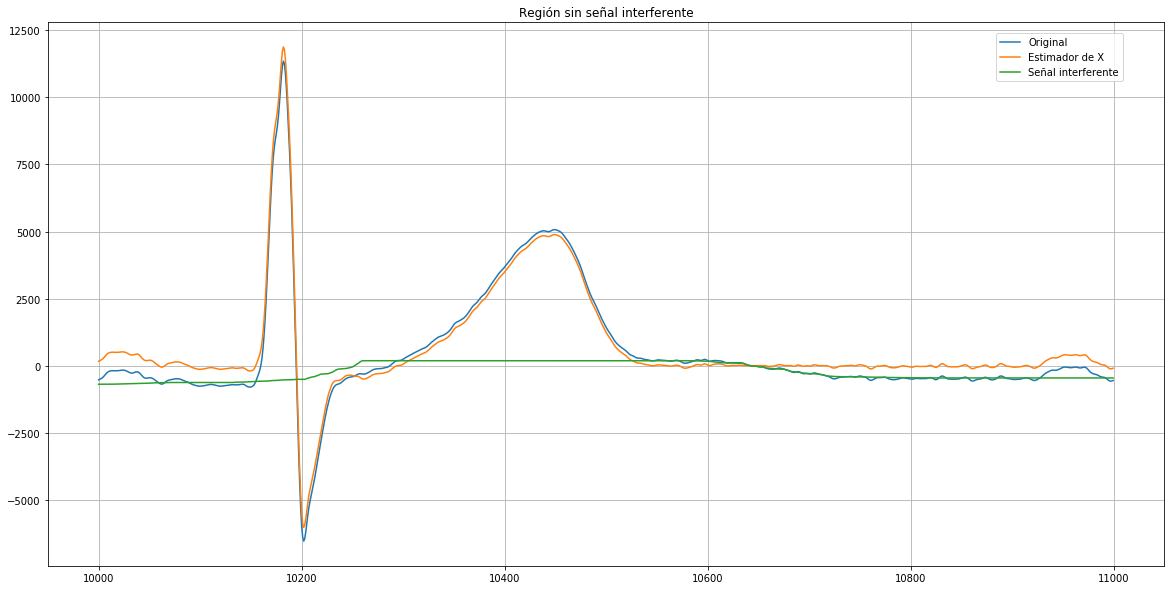

In [38]:
# Grafico las zonas de interes como resultado de aplicar el filtro de mediana
region = [np.arange(12*60*fs, 12.4*60*fs,dtype='uint') , np.arange(15*60*fs, 15.2*60*fs,dtype='uint')]

for reg in region:
    # Grafico la señal original y la filtrada en las zonas de interes
    plt.figure(figsize=(20,10))
    plt.plot(reg,ecg_one_lead[reg],label = 'Original')
    plt.plot(reg,estX[reg],label = 'Estimador de X')
    plt.plot(reg,estB[reg],label = 'Señal interferente')
    plt.legend(bbox_to_anchor=(0.85, 0.98), loc=2, borderaxespad=0.)
    plt.grid()

region = [np.arange(5*60*fs, 5.2*60*fs,dtype='uint') , np.arange(4000, 5500,dtype='uint'), np.arange(10e3, 11e3,dtype='uint')]

for reg in region:
    # Grafico la señal original y la filtrada en las zonas de interes
    plt.figure(figsize=(20,10))
    plt.title("Región sin señal interferente")
    plt.plot(reg,ecg_one_lead[reg],label = 'Original')
    plt.plot(reg,estX[reg],label = 'Estimador de X')
    plt.plot(reg,estB[reg],label = 'Señal interferente')
    plt.legend(bbox_to_anchor=(0.85, 0.98), loc=2, borderaxespad=0.)
    plt.grid()





<div class="alert alert-block alert-warning">
Este método de filtrado no lineal resulto muy efectivo para eliminar la señal interferente pero a costas de mucho tiempo computacional.
</div>

<div class="alert alert-block alert-info">
Para disminuir el tiempo de procesamiento voy a utilizar el filtrado de mediana pero aplicando una técnica de multirate. Lo que se busca es “reducir” la frecuencia de muestreo para que disminuya la cantidad de muestras a filtrar.
</div>

In [39]:
# Determino donde se concentra la mayor cantidad de energía de la señal interferente
# Obtengo la psd utilizando el metodo de Welch y el estimador de B obtenido anteriormente
L = 10000 #Largo de los bloques a promediar

psdWelch = np.zeros(shape=((L//2)+1,5))
f,psdWelchEstB = sig.welch(estB, fs, 'bartlett',nperseg=L, noverlap=L//2)

# Normalizo la psd
psdWelchEstB = psdWelchEstB/np.max(psdWelchEstB)

# Determino la banda de frecuencia que contiene el 98% de la energía de la señal interferente
enTot = np.sum(psdWelchEstB)
en98 = 0.98*enTot

suma = 0
for i in range(len(psdWelchEstB)):
    suma += psdWelchEstB[i]
    if suma >= en98:
        frec98 = f[i]
        break
    
print("En f="+str(frec98)+"Hz se encuentra el 98% de la energía de la señal")

En f=0.7000000000000001Hz se encuentra el 98% de la energía de la señal


C:\Users\Valentin\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
C:\Users\Valentin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


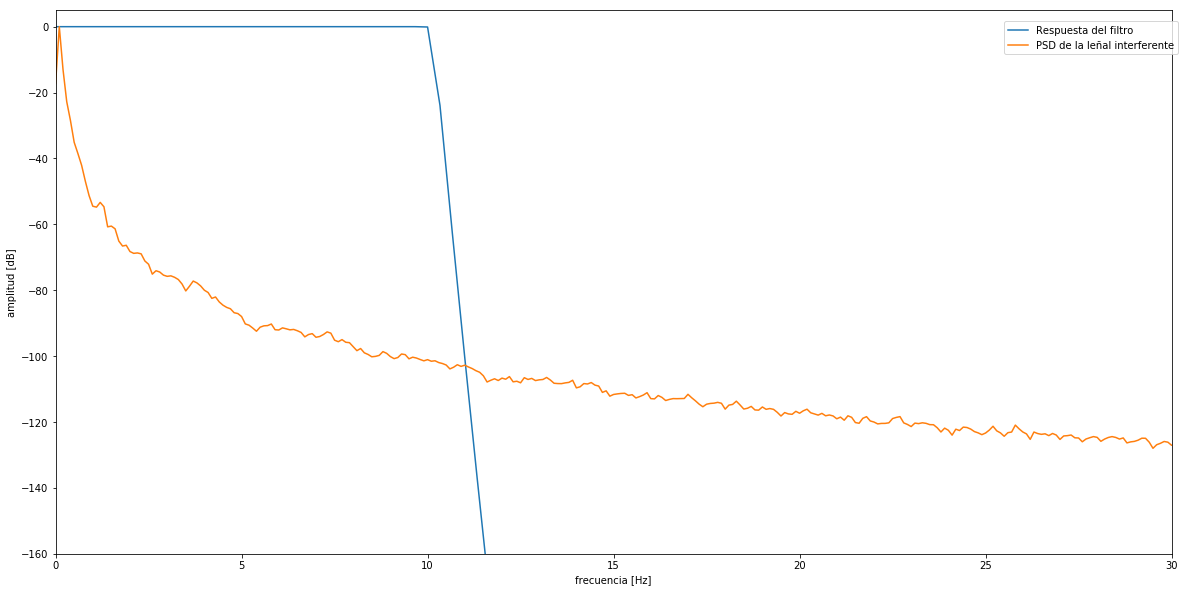

In [53]:
# Adopto como nueva frecuencia de Nyquist fn2 = 10Hz  =>  fs2=20Hz
# Antes de diezmar la señal la tengo que filtrar para impedir que se meta alias
# Determino las caracteristicas del filtro digital
fp0 = 10
fs0 = 11
attPaso = 0.1
attStop = 100

# Obtengo los parametros del filtro
bpSosButter = sig.iirdesign(wp=fp0/fn,ws=fs0/fn,gpass=attPaso,gstop=attStop,analog=False,ftype='butter',output='sos')
wB,hB = sig.sosfreqz(bpSosButter, worN=1500)

# Grafico la respuesta del filtro y la psd de la interferente
plt.figure(figsize=(20,10))
plt.plot(fn*(wB/np.pi),20*np.log10(np.abs(hB)),label = 'Respuesta del filtro')
plt.plot(f,20*np.log10(psdWelchEstB),label = 'PSD de la leñal interferente')
plt.legend(bbox_to_anchor=(0.85, 0.98), loc=2, borderaxespad=0.)
plt.axis([0,30,-160,5])
plt.ylabel('amplitud [dB]')
plt.xlabel('frecuencia [Hz]')
plt.grid()

plt.grid()

In [41]:
# Guardo el timepo en este instante para poder determinar el timepo de procesamiento total con este metodo
tStartDiezmado = time()

# Filtro la señal original 
ecgB = sig.sosfiltfilt(bpSosButter, ecg_one_lead) 

# Diezmo la señal, la muestreo  a fs2 = 20Hz => 50 veces menos que fs1=1000Hz
fs2 = 20
fn2 = fs2/2

# Descarto las muestras que no me interesan
ecgD = ecgB[0:N:50]

N2 = len(ecgD)

# Le aplico el primer filtro de mediana de 3 muestras
ecgD_med3 = sig.medfilt(ecgD,3)

# Le aplico el segundo filtro de mediana de 17 muestras
estBD = sig.medfilt(ecgD_med3,17)

# Interpolo ceros en el estimador de la señal interferente obtenida
estBZ = np.zeros(N)
estBZ[0:N:50] = estBD

# Filtro la señal interpolada
estBmr = sig.sosfiltfilt(bpSosButter, estBZ) 

# Escalo la señal resultante
maxBZ = np.max(estBZ)
estBmr = maxBZ*estBmr/np.max(estBmr)

# Calculo el timepo de procesado
dtDiezmado = time()-tStartDiezmado

# Le resto la interferente a la señal de ecg original
estXmr = ecg_one_lead - estBmr

C:\Users\Valentin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


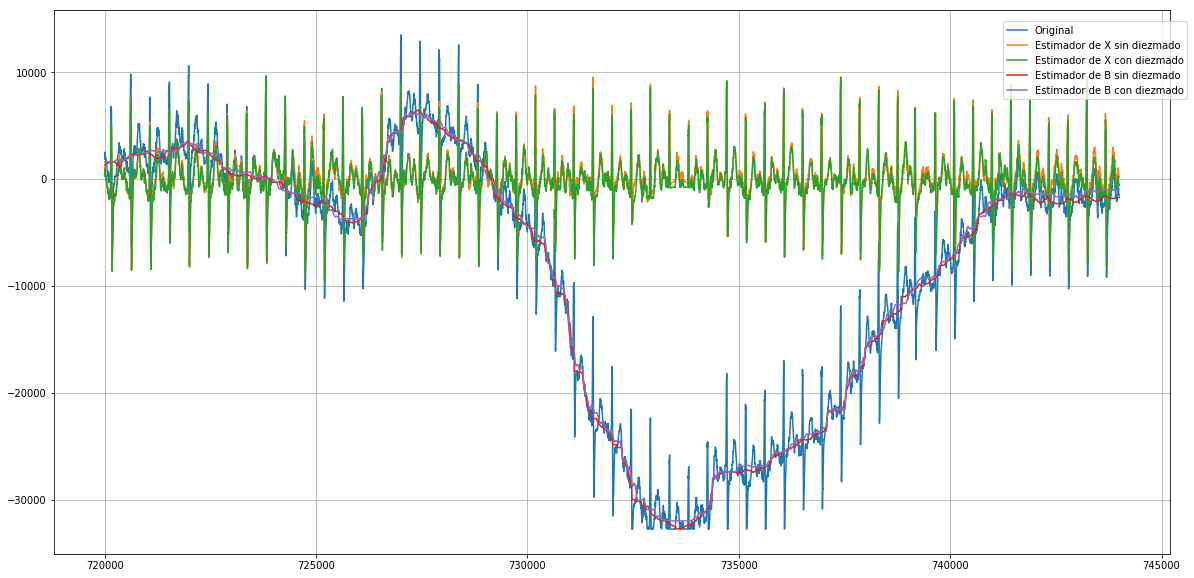

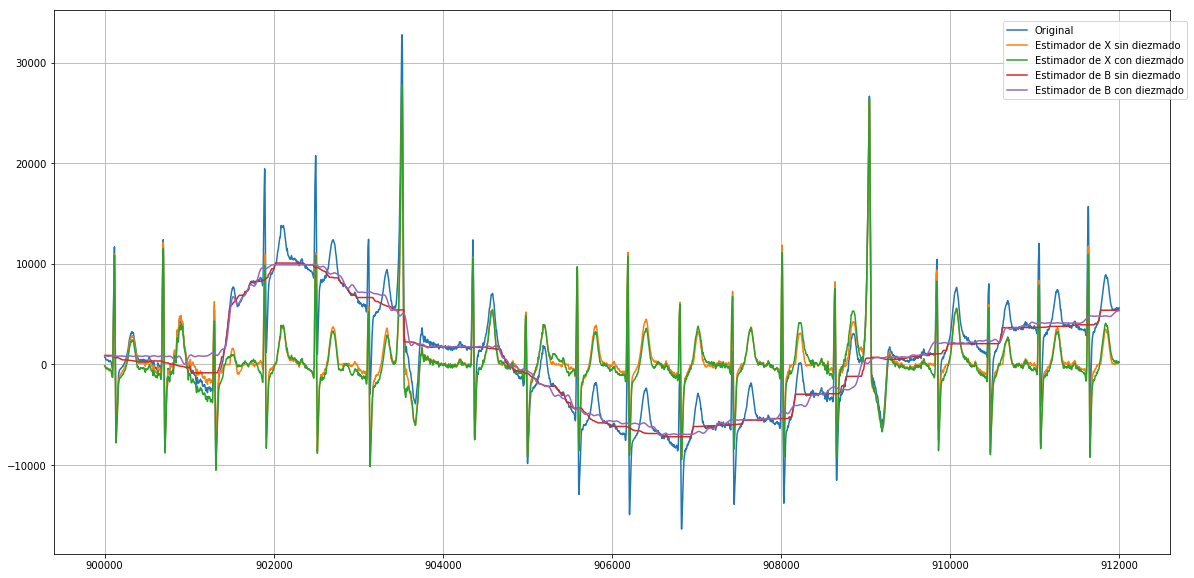

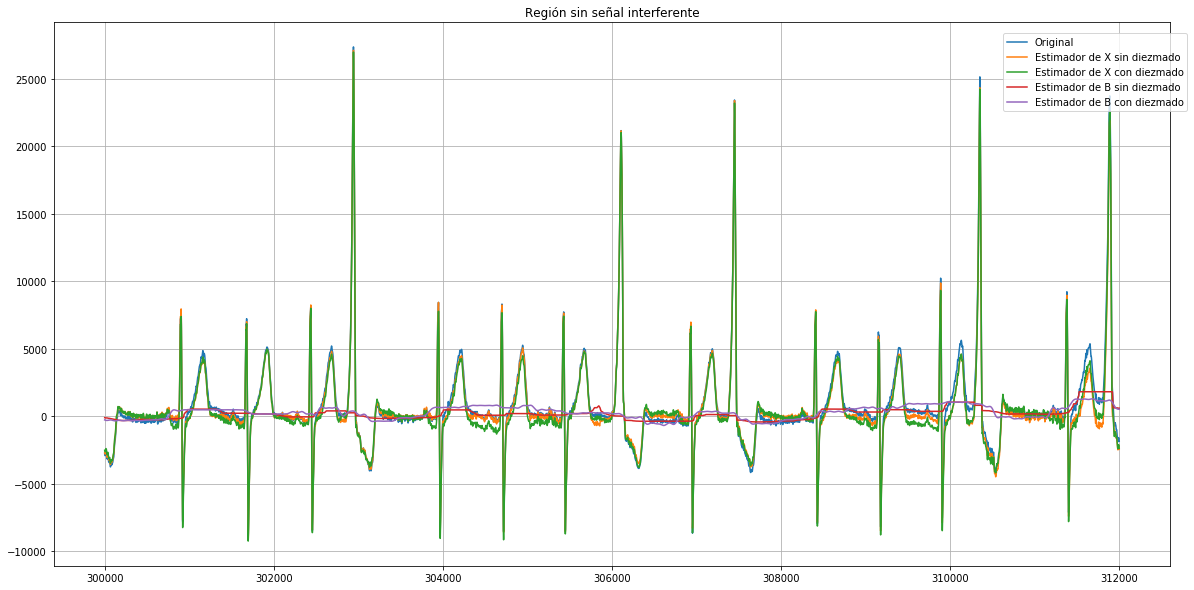

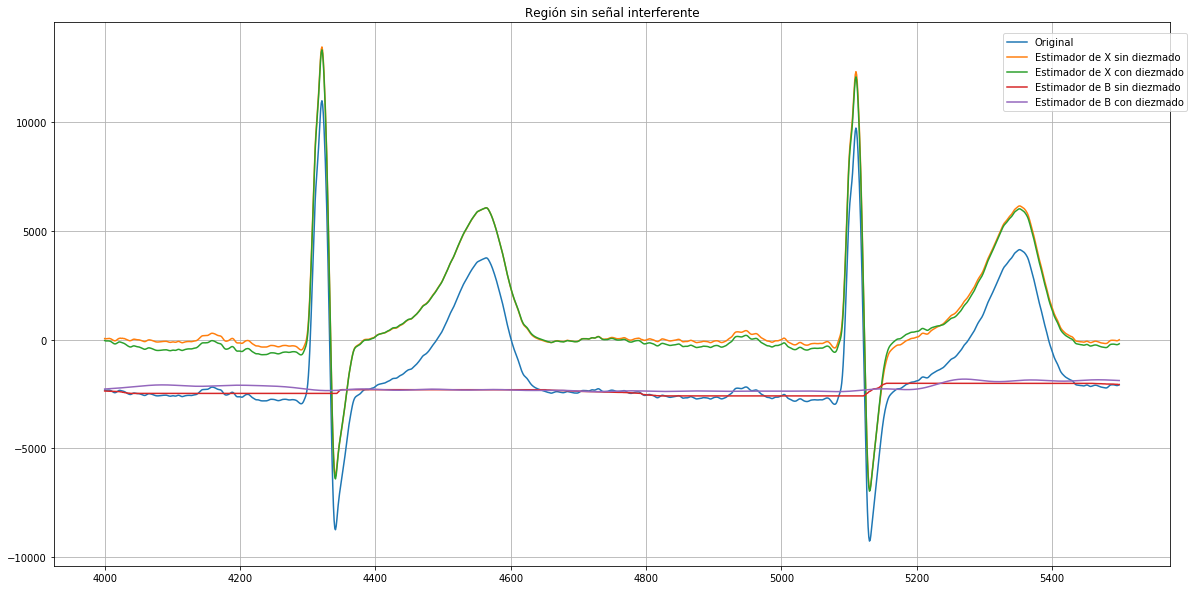

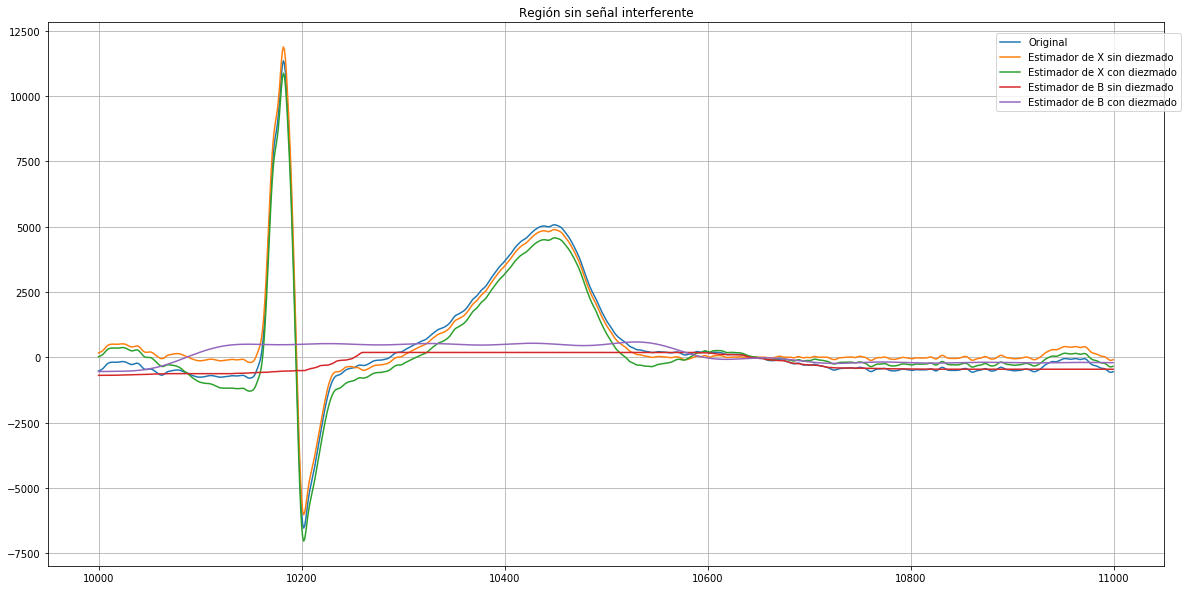

In [46]:
# Grafico las zonas de interes 
regionInt = [np.arange(720000, 744000,dtype='uint') , np.arange(900000, 912000,dtype='uint')]

for reg in regionInt:
    # Grafico la señal original y la filtrada en las zonas de interes
    plt.figure(figsize=(20,10))
    plt.plot(reg,ecg_one_lead[reg],label = 'Original')
    plt.plot(reg,estX[reg],label = 'Estimador de X sin diezmado')
    plt.plot(reg,estXmr[reg],label = 'Estimador de X con diezmado')
    plt.plot(reg,estB[reg],label = 'Estimador de B sin diezmado')
    plt.plot(reg,estBmr[reg],label = 'Estimador de B con diezmado')
    plt.legend(bbox_to_anchor=(0.85, 0.98), loc=2, borderaxespad=0.)
    plt.grid()

regionNoInt = [np.arange(300000, 312000,dtype='uint') , np.arange(4000, 5500,dtype='uint'), np.arange(10e3, 11e3,dtype='uint')]

for reg in regionNoInt:
    # Grafico la señal original y la filtrada en las zonas de interes
    plt.figure(figsize=(20,10))
    plt.title("Región sin señal interferente")
    plt.plot(reg,ecg_one_lead[reg],label = 'Original')
    plt.plot(reg,estX[reg],label = 'Estimador de X sin diezmado')
    plt.plot(reg,estXmr[reg],label = 'Estimador de X con diezmado')
    plt.plot(reg,estB[reg],label = 'Estimador de B sin diezmado')
    plt.plot(reg,estBmr[reg],label = 'Estimador de B con diezmado')
    plt.legend(bbox_to_anchor=(0.85, 0.98), loc=2, borderaxespad=0.)
    plt.grid()

In [66]:
# Comparo los tiempos de procesamiento 
resultado = [[str(dtMediana),""],[str(dtDiezmado),str(-(100-100*dtDiezmado/dtMediana))]]

df = DataFrame(resultado, columns=['Tiempo de procesamiento [Seg]','Porcentaje %'],
               index=['sin diezmado', 'con diezmado'])
HTML(df.to_html())

,Tiempo de procesamiento [Seg],Porcentaje %
sin diezmado,92.48529005050659,
con diezmado,4.082233667373657,-95.58607248228952


<div class="alert alert-block alert-warning">
Se puede ver que disminuyendo la cantidad de muestras a filtrar, mediante el diezmado de la señal, el tiempo de procesamiento disminuye conciderablemente y los estimadores son similares. 
</div>

b) Estimación del movimiento de línea de base a partir de los segmentos isoeléctricos de cada latido. A partir de las detecciones provistas, puede estimar aproximadamente el nivel isoeléctrico, es decir el momento donde la actividad eléctrica cardíaca es **nula**. El intervalo entre la onda P y Q, es un buen momento para estimar las características de las señales interferentes que originan el movimiento de la línea de base.

<img src="./pq.png" align="center" width="80%" /> 

Para la localización del segmento PQ puede valerse de la localización de cada latido (líneas rojas verticales) y a partir de la misma, anticipar un tiempo adecuado de manera tal de no incluir la onda P ni Q. Puede ayudarse con el latido promedio de un latido normal para establecer dicho intervalo.

Recuerde que la señal de línea de base debe estar muestreada a la misma frecuencia que el ECG, por lo que debería remuestrear dicha señal (puede usar la función de interpolación spline para ello).

<div class="alert alert-block alert-success">
<b>Ayuda:</b> Puede utilizar la función de interpolación <a href="https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.CubicSpline.html">spline <b>scipy.interpolate.CubicSpline</b></a>
</div>

In [57]:
# Cargo las señales
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = np.reshape(ecg_one_lead,len(ecg_one_lead))

posQRS = mat_struct['qrs_detections']
posQRS = np.reshape(posQRS,len(posQRS))

N = len(ecg_one_lead)

fs = 1000
fn = fs/2

qrs = np.ones(len(posQRS))

# Asumo que el nivel isoeléctrico esta 70ms antes del latido 
# Genero una matriz con los niveles isoeléctricos, no tomo un solo punto, si no
# que voy a promediar determinada cantidad L de puntos que se encuentren en el intervalo PQ
L = 30
dt = 70

nIso = []
for i in posQRS:
  nIso.append(ecg_one_lead[i-dt-(L//2):i-dt+(L//2)])
  
nIso = np.array(nIso)

# Promedio los segmentos
nIso = np.transpose(np.mean(nIso, axis=1))

# Interpolo los puntos para obtener el estimador de la señal interferente
cs = CubicSpline(posQRS-dt, nIso)
estBni = cs(np.arange(N))

# Obtengo el estimador x del ecg
estXni = ecg_one_lead-estBni


C:\Users\Valentin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


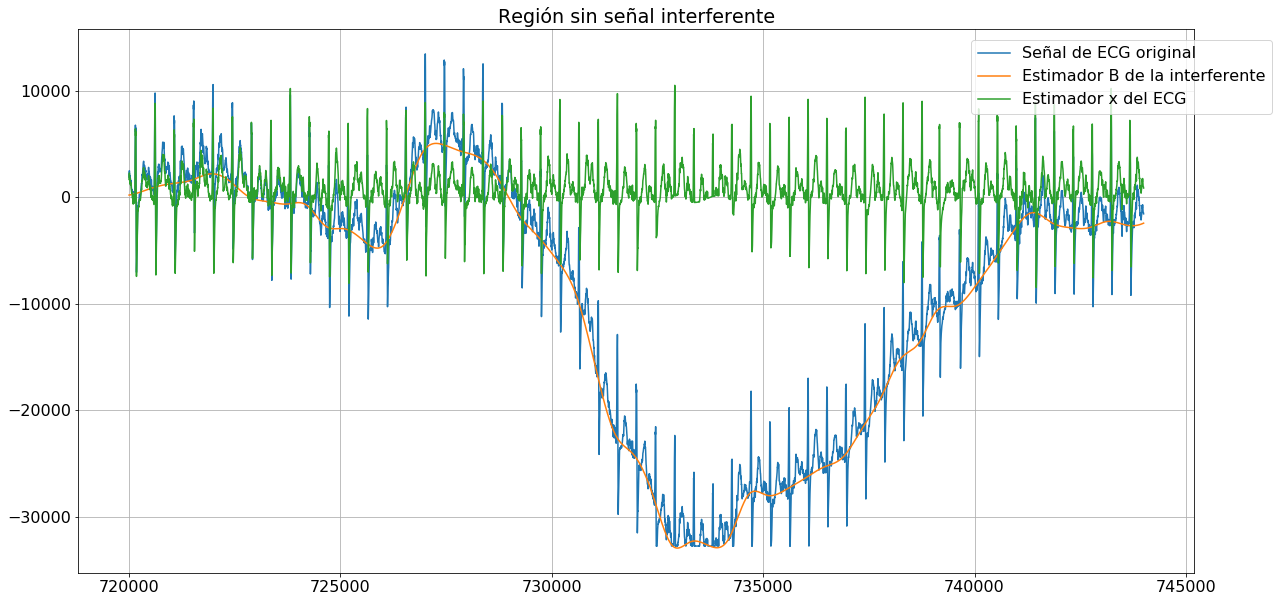

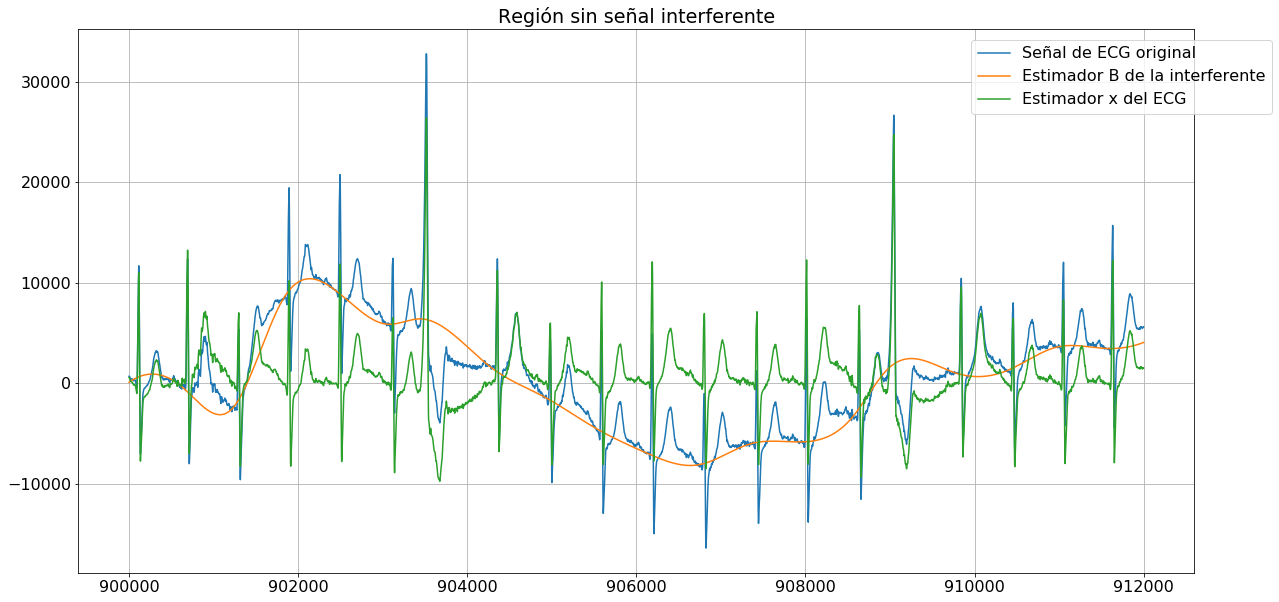

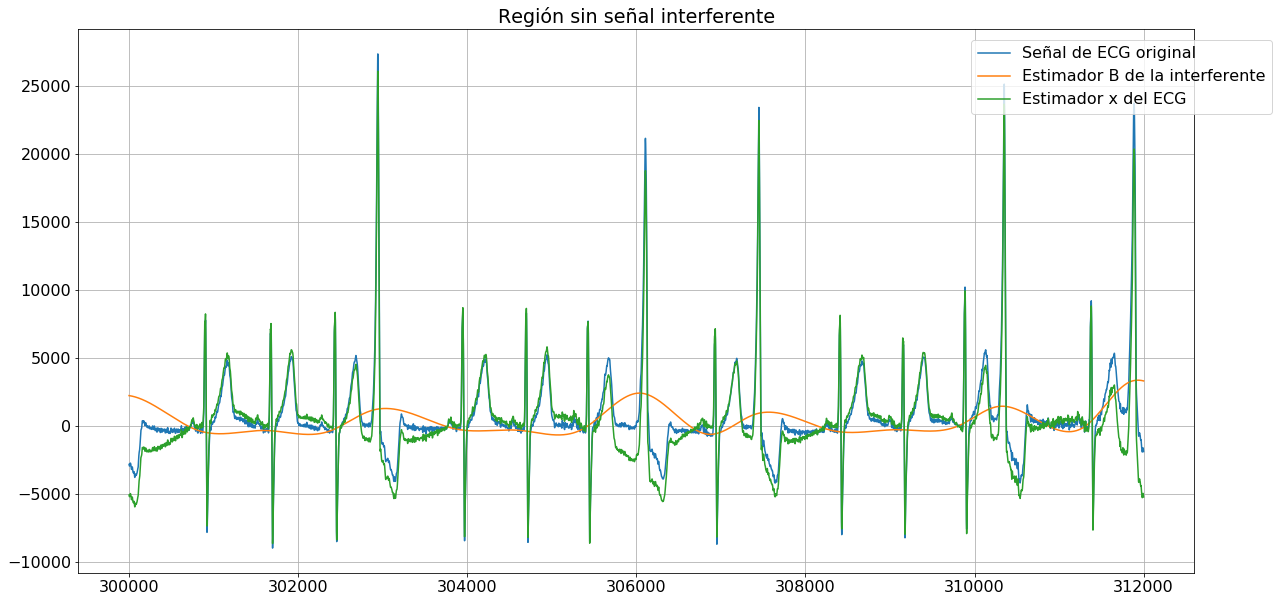

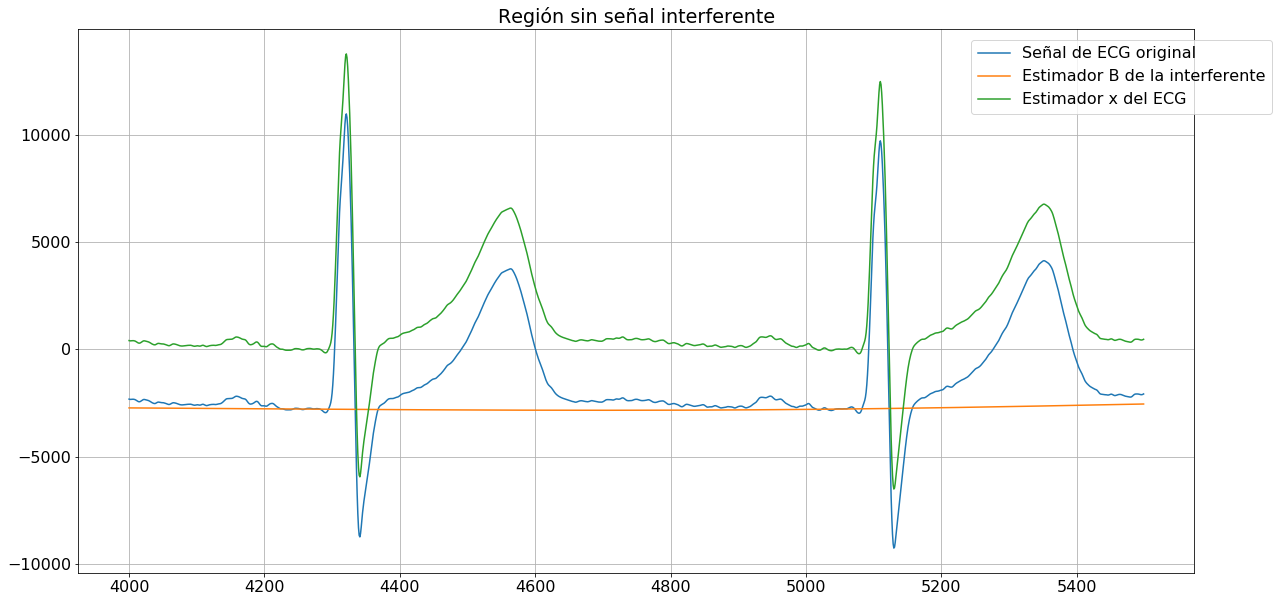

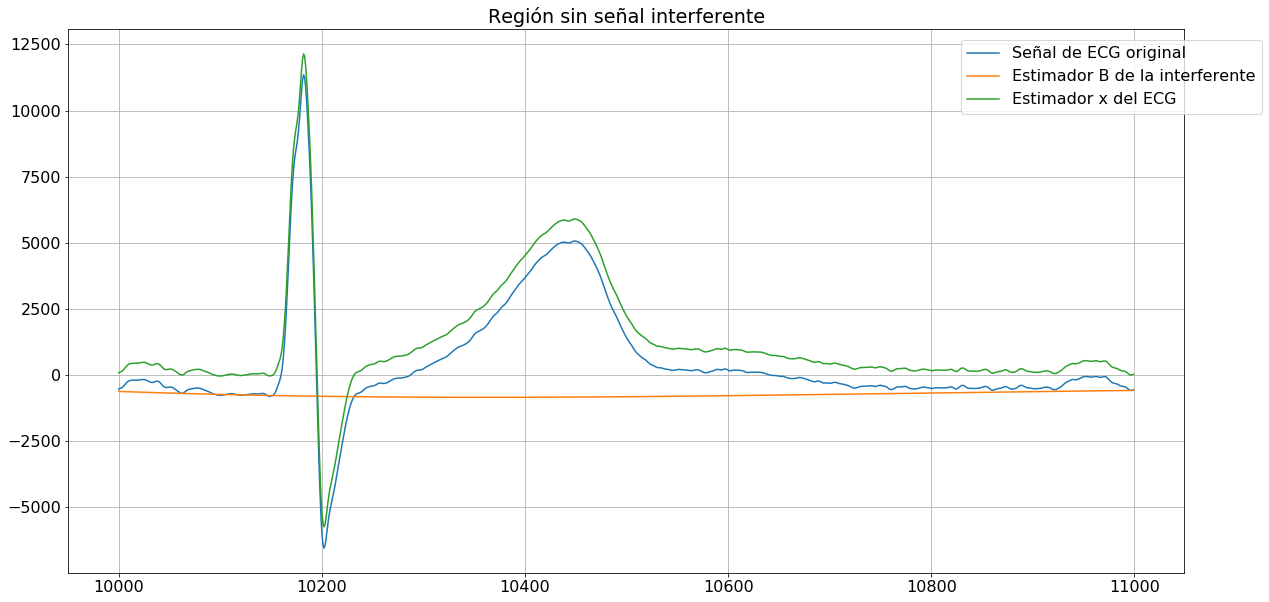

In [61]:
# Grafico las zonas de interes 
regionInt = [np.arange(720000, 744000,dtype='uint') , np.arange(900000, 912000,dtype='uint')]

for reg in regionInt:
    # Grafico la señal original y la filtrada en las zonas de interes
    plt.figure(figsize=(20,10))
    plt.title("Región sin señal interferente")
    plt.plot(reg,ecg_one_lead[reg],label = "Señal de ECG original")
    plt.plot(reg,estBni[reg],label = "Estimador B de la interferente")
    plt.plot(reg,estXni[reg],label = "Estimador x del ECG")
    plt.legend(bbox_to_anchor=(0.80, 0.98), loc=2, borderaxespad=0.)
    plt.grid()

regionNoInt = [np.arange(300000, 312000,dtype='uint') , np.arange(4000, 5500,dtype='uint'), np.arange(10e3, 11e3,dtype='uint')]

for reg in regionNoInt:
    # Grafico la señal original y la filtrada en las zonas de interes
    plt.figure(figsize=(20,10))
    plt.title("Región sin señal interferente")
    plt.plot(reg,ecg_one_lead[reg],label = "Señal de ECG original")
    plt.plot(reg,estBni[reg],label = "Estimador B de la interferente")
    plt.plot(reg,estXni[reg],label = "Estimador x del ECG")
    plt.legend(bbox_to_anchor=(0.80, 0.98), loc=2, borderaxespad=0.)
    plt.grid()
    
    


<div class="alert alert-block alert-warning">
<b>Respuesta:</b> Escriba aquí su respuesta.
</div>

<div class="alert alert-block alert-info">
<b>6)</b> Para la señal de ECG provista junto con este documento, aplique el concepto de <b>filtro adaptado</b> y otras técnicas de filtrado digital para diseñar un detector de latidos. Los patrones provistos son:

</div>


 - **qrs_pattern1**: Complejo de ondas QRS normal
 - **heartbeat_pattern1**: Latido normal
 - **heartbeat_pattern2**: Latido de origen ventricular
 

<div class="alert alert-block alert-success">
<b>Ayuda:</b> Revise el concepto de filtro adaptado en <a href="http://en.wikipedia.org/wiki/Matched_filter">Wikipedia</a>, o la bibliografía de la materia (Porat 14.4.9).
</div>

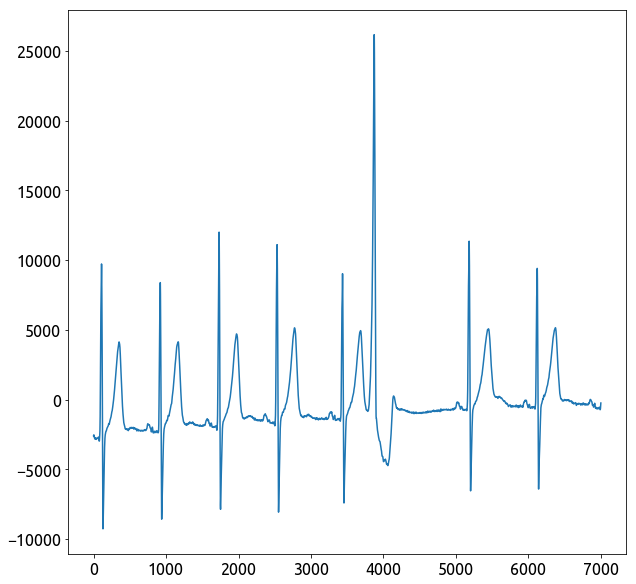

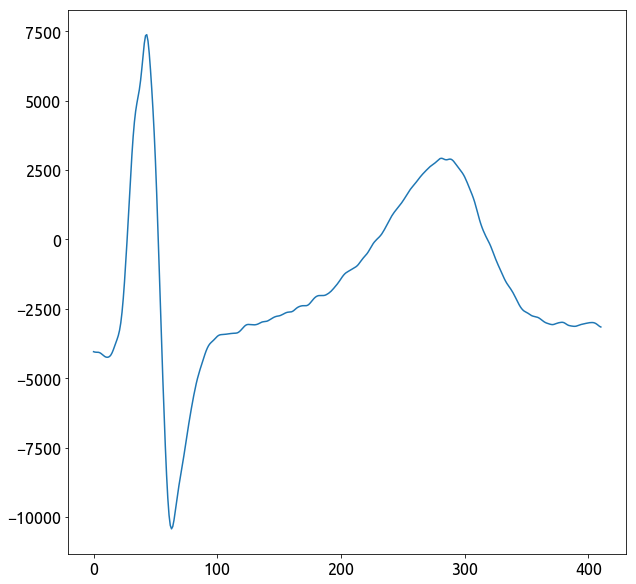

In [54]:
import scipy.io as sio

##########################################
# Acá podés generar los gráficos pedidos #
##########################################

# para listar las variables que hay en el archivo
#io.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N = len(ecg_one_lead)

hb_1 = vertical_flaten(mat_struct['heartbeat_pattern1'])

plt.figure(1)
plt.plot(ecg_one_lead[5000:12000])

plt.figure(2)
plt.plot(hb_1)



a) Explique conceptualmente cómo podría realizar un detector de latidos con la señal resultante del filtro adaptado. Discuta la utilidad y limitaciones de este método. 

<div class="alert alert-block alert-warning">
<b>Respuesta:</b> Escriba aquí su respuesta.
</div>

   
   b) Realice la detección de los latidos, comparando las detecciones obtenidas con las que se incluyen en la variable **qrs_detections**. Proponga alguna métrica para cuantificar las diferencias.


In [ ]:

##########################################
# Acá podés generar los gráficos pedidos #
##########################################

